# NAG Experiments

Gettin the data

In [1]:
import datautils
import pandas as pd
import modelutils as mu
import nesterov
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import itertools

In [2]:
DATASET = "Dataset/ML-CUP23-TR.csv"
RESULTS = "Results/"
PLOT = "Plots/"
RUNS = "FullRuns/"

In [3]:
df_cup = pd.read_csv(DATASET, skiprows=6)
df_cup.rename(columns={"# Training set: ID": "ID"}, inplace=True)

In [4]:
df_cup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1000 non-null   int64  
 1   x1      1000 non-null   float64
 2   x2      1000 non-null   float64
 3   x3      1000 non-null   float64
 4   x4      1000 non-null   float64
 5   x5      1000 non-null   float64
 6   x6      1000 non-null   float64
 7   x7      1000 non-null   float64
 8   x8      1000 non-null   float64
 9   x9      1000 non-null   float64
 10  x10     1000 non-null   float64
 11  y1      1000 non-null   float64
 12  y2      1000 non-null   float64
 13  y3      1000 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 109.5 KB


In [5]:
X_train, y_train = datautils.obtain_features_targets(df_cup)
print(X_train.shape, y_train.shape)

input_size = X_train.shape[1]
output_size = y_train.shape[1]
input_size, output_size

(1000, 10) (1000, 3)


(10, 3)

## Section about matrix conditioning

In [6]:
from tqdm import tqdm

In [35]:
alpha = 1e-2

train_cond = np.linalg.cond(X_train)
print(f"Train set conditioning: {train_cond}")

cond_input_weights_means = []
cond_A_means = []
cond_AtA_means = []
cond_BtB_means = []

for HIDDEN_SIZE in tqdm(range(50, 1001, 50), desc="Hidden Size Loop"):
    cond_input_weights = []
    cond_A = []
    cond_AtA = []
    cond_BtB = []
    for seed in range(4):
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        cond_input_weights.append(np.linalg.cond(model_true.input_weights))

        A = model_true.hidden_activations(X_train)
        cond_A.append(np.linalg.cond(A))

        AtA = A.T @ A
        cond_AtA.append(np.linalg.cond(AtA))
        BtB = AtA + alpha * np.eye(model_true.hidden_size)
        cond_BtB.append(np.linalg.cond(BtB))

    cond_input_weights_means.append(np.mean(cond_input_weights))
    cond_A_means.append(np.mean(cond_A))
    cond_AtA_means.append(np.mean(cond_AtA))
    cond_BtB_means.append(np.mean(cond_BtB))


# for HIDDEN_SIZE in range(50,10001,50):
#     model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=0)
#     conditioning = np.linalg.cond(model_true.input_weights)
#     print(
#         f"Conditioning of input weights for HIDDEN_SIZE {HIDDEN_SIZE}: {conditioning}"
#     )

#     A = model_true.hidden_activations(X_train)
#     conditioning = np.linalg.cond(A)
#     print(f"Conditioning of A for HIDDEN_SIZE {HIDDEN_SIZE}: {conditioning}")

#     AtA = A.T @ A + alpha * np.eye(model_true.hidden_size)

#     big_cond = np.linalg.cond(AtA)

#     print(f"conditioning of AtA: {big_cond}")

#     # guarantee posdef in case of numerical errors (happens for large hidden sizes)
#     # NOTE: investigate what gradient descent does, however alpha propably guarantees always posdef
#     # eig_min = np.min(np.linalg.eigvals(AtA))
#     # old_tau = max(0, -eig_min)
#     # BtB = AtA + (old_tau + 1e-2) * np.eye(model_true.hidden_size)

#     # eigenvalues = np.linalg.eigvalsh(BtB)
#     # L = np.max(eigenvalues)
#     # tau = np.min(eigenvalues)

Train set conditioning: 7.674557171236154


Hidden Size Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Hidden Size Loop: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


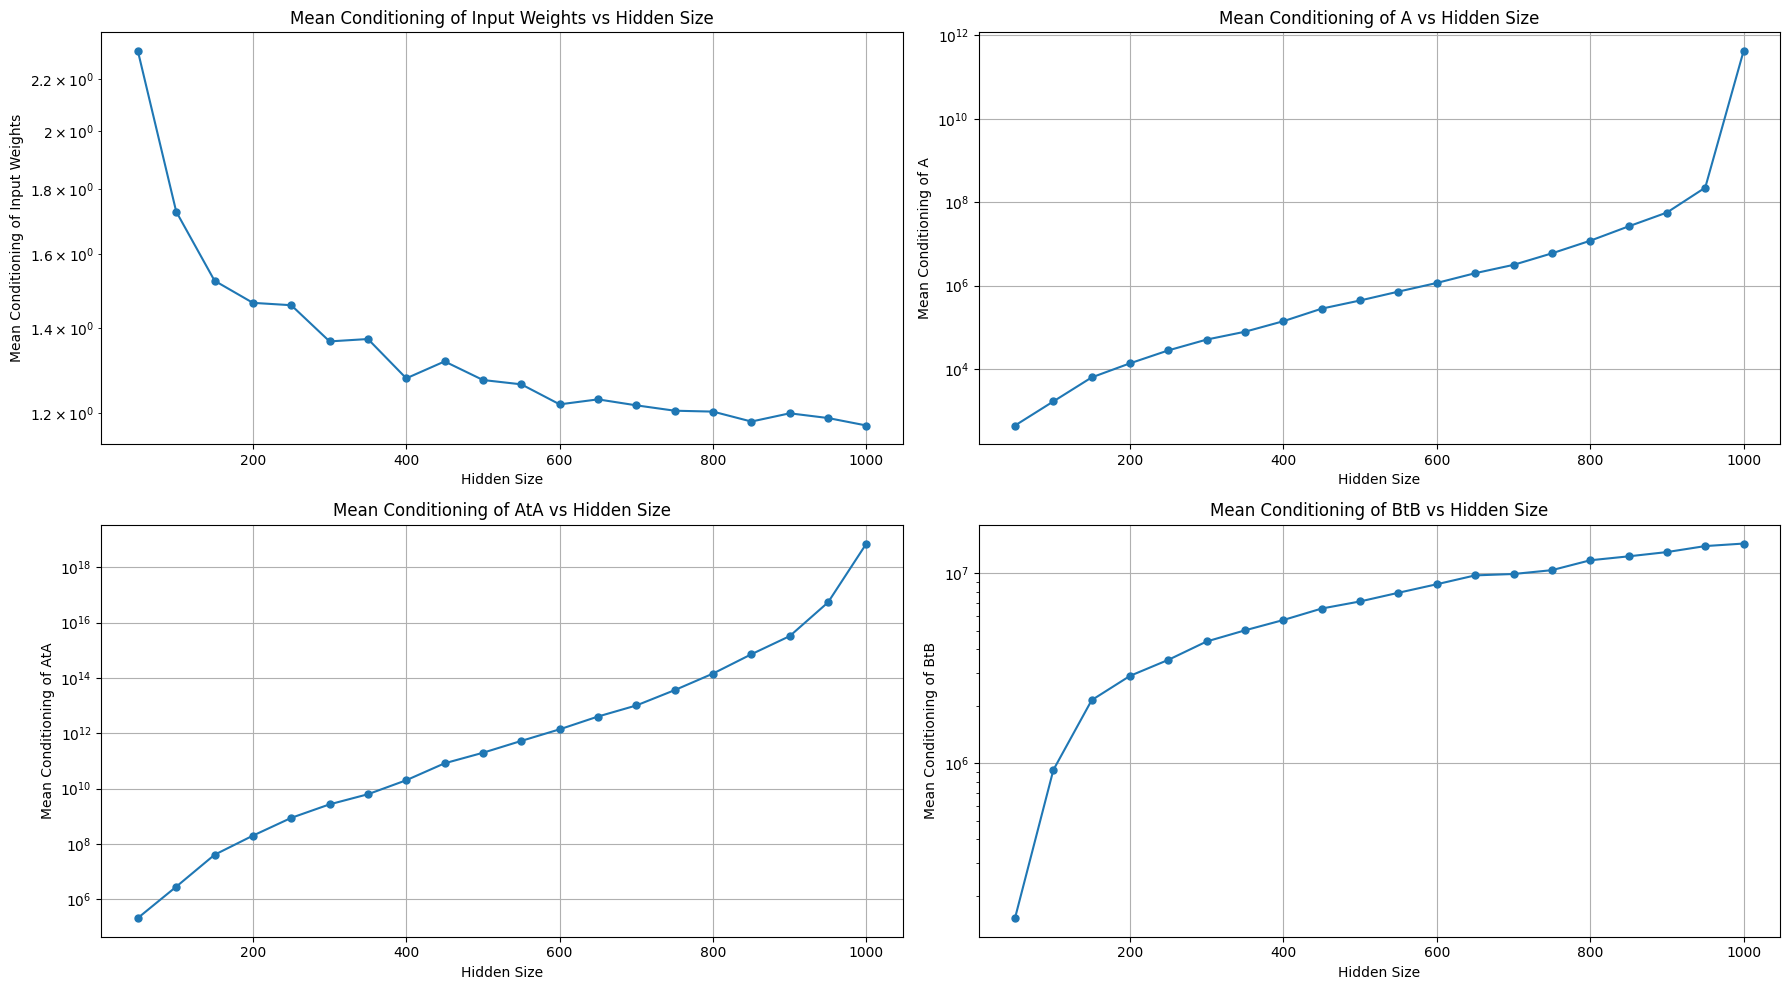

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
marker_style = dict(marker="o", markersize=5, linestyle="-")
axs[0, 0].plot(range(50, 1001, 50), cond_input_weights_means, **marker_style)
axs[0, 0].set_title("Mean Conditioning of Input Weights vs Hidden Size")
axs[0, 0].set_xlabel("Hidden Size")
axs[0, 0].set_ylabel("Mean Conditioning of Input Weights")
axs[0, 0].set_yscale("log")
axs[0, 0].grid(True)

axs[0, 1].plot(range(50, 1001, 50), cond_A_means, **marker_style)
axs[0, 1].set_title("Mean Conditioning of A vs Hidden Size")
axs[0, 1].set_xlabel("Hidden Size")
axs[0, 1].set_ylabel("Mean Conditioning of A")
axs[0, 1].set_yscale("log")
axs[0, 1].grid(True)

axs[1, 0].plot(range(50, 1001, 50), cond_AtA_means, **marker_style)
axs[1, 0].set_title("Mean Conditioning of AtA vs Hidden Size")
axs[1, 0].set_xlabel("Hidden Size")
axs[1, 0].set_ylabel("Mean Conditioning of AtA")
axs[1, 0].set_yscale("log")
axs[1, 0].grid(True)

axs[1, 1].plot(range(50, 1001, 50), cond_BtB_means, **marker_style)
axs[1, 1].set_title("Mean Conditioning of BtB vs Hidden Size")
axs[1, 1].set_xlabel("Hidden Size")
axs[1, 1].set_ylabel("Mean Conditioning of BtB")
axs[1, 1].set_yscale("log")
axs[1, 1].grid(True)

plt.tight_layout()
# plt.savefig("Plots/Conditioning")
plt.show()

In [102]:
min_sv_X_train = []
max_sv_X_train = []
min_sv_input_weights = []
max_sv_input_weights = []
min_sv_A = []
max_sv_A = []

for HIDDEN_SIZE in tqdm(range(2, 12), desc="Hidden Size Loop"):
    sv_X_train = np.linalg.svd(X_train, compute_uv=False)
    min_sv_X_train.append(np.min(sv_X_train))
    max_sv_X_train.append(np.max(sv_X_train))

    sv_input_weights = []
    sv_A = []
    for seed in range(4):
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        sv_input_weights.append(
            np.linalg.svd(model_true.input_weights, compute_uv=False)
        )
        A = X_train.dot(model_true.input_weights)
        sv_A.append(np.linalg.svd(A, compute_uv=False))

    min_sv_input_weights.append(np.mean([np.min(sv) for sv in sv_input_weights]))
    max_sv_input_weights.append(np.mean([np.max(sv) for sv in sv_input_weights]))
    # For A, compute the second lowest singular value instead of the minimum
    min_sv_A.append(np.mean([np.partition(sv, 1)[0] for sv in sv_A]))
    # min_sv_A.append(np.mean([np.min(sv) for sv in sv_A]))
    max_sv_A.append(np.mean([np.max(sv) for sv in sv_A]))


print(min_sv_X_train[0], max_sv_X_train[0])
print(min_sv_input_weights[0], max_sv_input_weights[0])

Hidden Size Loop: 100%|██████████| 10/10 [00:00<00:00, 711.63it/s]

7.226603333251899 55.46098043488745
0.8635862553531773 1.1999401390350204


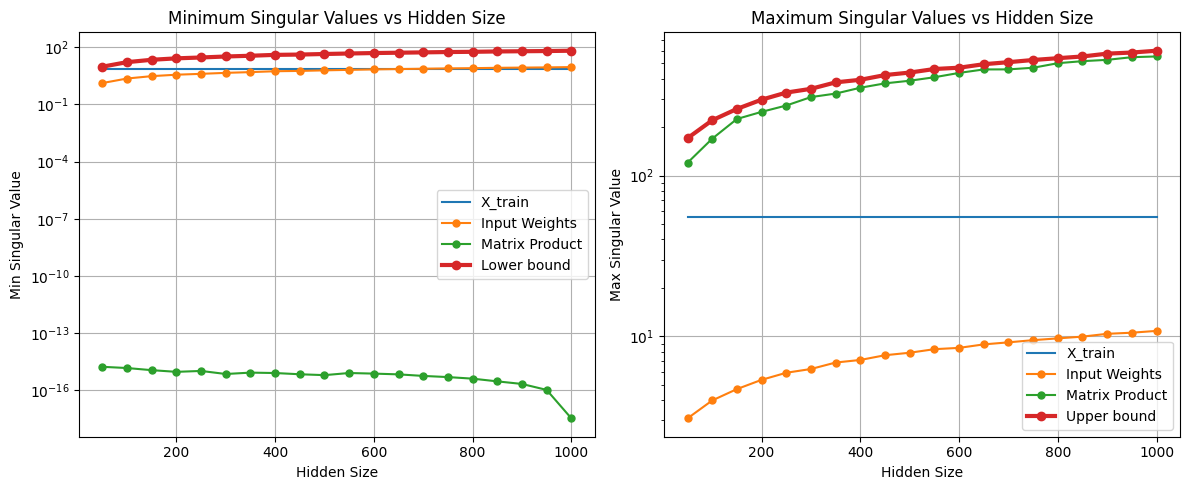

In [96]:
plt.figure(figsize=(12, 5))

# Plot min singular values
plt.subplot(1, 2, 1)
plt.plot(range(50, 1001, 50), min_sv_X_train, label="X_train")
plt.plot(
    range(50, 1001, 50), min_sv_input_weights, label="Input Weights", **marker_style
)
plt.plot(range(50, 1001, 50), min_sv_A, label="Matrix Product", **marker_style)
plt.plot(
    range(50, 1001, 50),
    [a * b for a, b in zip(min_sv_X_train, min_sv_input_weights)],
    linewidth=3,
    marker="o",
    label="Lower bound",
)
plt.title("Minimum Singular Values vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Min Singular Value")
plt.yscale("log")
plt.grid(True)
plt.legend()

# Plot max singular values
plt.subplot(1, 2, 2)
plt.plot(range(50, 1001, 50), max_sv_X_train, label="X_train")
plt.plot(
    range(50, 1001, 50), max_sv_input_weights, label="Input Weights", **marker_style
)
plt.plot(range(50, 1001, 50), max_sv_A, label="Matrix Product", **marker_style)
plt.plot(
    range(50, 1001, 50),
    [a * b for a, b in zip(max_sv_X_train, max_sv_input_weights)],
    linewidth=3,
    marker="o",
    label="Upper bound",
)
plt.title("Maximum Singular Values vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Max Singular Value")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.savefig("Plots/svd_large")
plt.tight_layout()
plt.show()

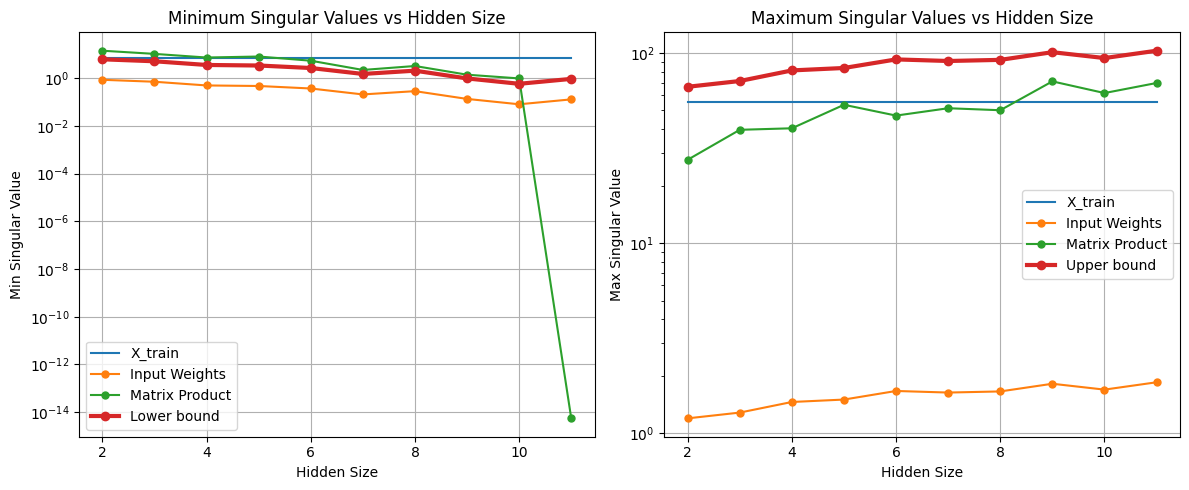

In [100]:
plt.figure(figsize=(12, 5))

# Plot min singular values
plt.subplot(1, 2, 1)
plt.plot(range(2, 2 + len(min_sv_A)), min_sv_X_train, label="X_train")
plt.plot(
    range(2, 2 + len(min_sv_A)),
    min_sv_input_weights,
    label="Input Weights",
    **marker_style
)
plt.plot(range(2, 2 + len(min_sv_A)), min_sv_A, label="Matrix Product", **marker_style)
plt.plot(
    range(2, 2 + len(min_sv_A)),
    [a * b for a, b in zip(min_sv_X_train, min_sv_input_weights)],
    linewidth=3,
    marker="o",
    label="Lower bound",
)
plt.title("Minimum Singular Values vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Min Singular Value")
plt.yscale("log")
plt.grid(True)
plt.legend()

# Plot max singular values
plt.subplot(1, 2, 2)
plt.plot(range(2, len(max_sv_X_train) + 2), max_sv_X_train, label="X_train")
plt.plot(
    range(2, len(max_sv_input_weights) + 2),
    max_sv_input_weights,
    label="Input Weights",
    **marker_style
)

plt.plot(range(2, 2 + len(max_sv_A)), max_sv_A, label="Matrix Product", **marker_style)
plt.plot(
    range(2, 2 + len(max_sv_A)),
    [a * b for a, b in zip(max_sv_X_train, max_sv_input_weights)],
    linewidth=3,
    marker="o",
    label="Upper bound",
)
plt.title("Maximum Singular Values vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Max Singular Value")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.savefig("Plots/svd_small")
plt.tight_layout()
plt.show()

Condition number of input weights: 234.60921541241592
Condition number of A: 560.2260380995274


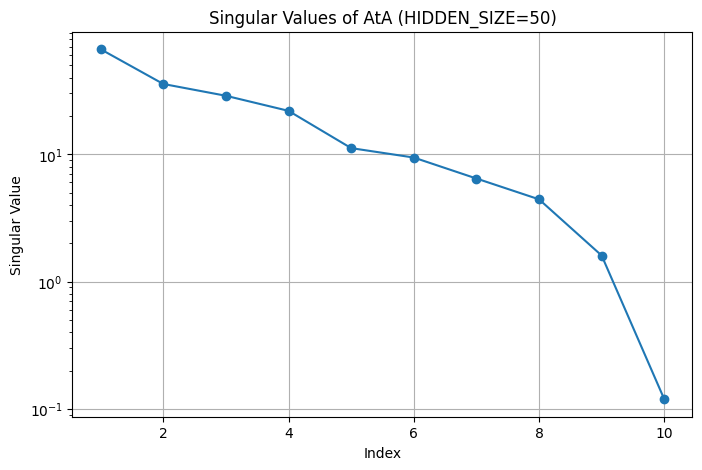

In [84]:
# Compute SVD of AtA for model with 50 hidden units
HIDDEN_SIZE = 10
seed = 0  # you can change the seed if needed


model_50 = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
A_50 = X_train @ model_50.input_weights  # model_50.hidden_activations(X_train)
AtA_50 = A_50.T @ A_50

print("Condition number of input weights:", np.linalg.cond(model_50.input_weights))
print("Condition number of A:", np.linalg.cond(A_50))


# Compute singular values of AtA_50
svd_AtA_50 = np.linalg.svd(A_50, compute_uv=False)

# Plot the singular values
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(svd_AtA_50) + 1), svd_AtA_50, marker="o")
plt.yscale("log")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.title("Singular Values of AtA (HIDDEN_SIZE=50)")
plt.grid(True)
plt.show()

In [ ]:
eig_min_AtA_means = []
eig_min_BtB_means = []


for HIDDEN_SIZE in tqdm(range(50, 1001, 50), desc="Hidden Size Loop"):
    eig_min_AtA = []
    eig_min_BtB = []
    for seed in range(4):
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        A = model_true.hidden_activations(X_train)
        AtA = A.T @ A
        BtB = AtA + alpha * np.eye(model_true.hidden_size)

        eig_min_AtA.append(np.min(np.linalg.eigvalsh(AtA)))
        eig_min_BtB.append(np.min(np.linalg.eigvalsh(BtB)))

    eig_min_AtA_means.append(np.mean(eig_min_AtA))
    eig_min_BtB_means.append(np.mean(eig_min_BtB))

Hidden Size Loop: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


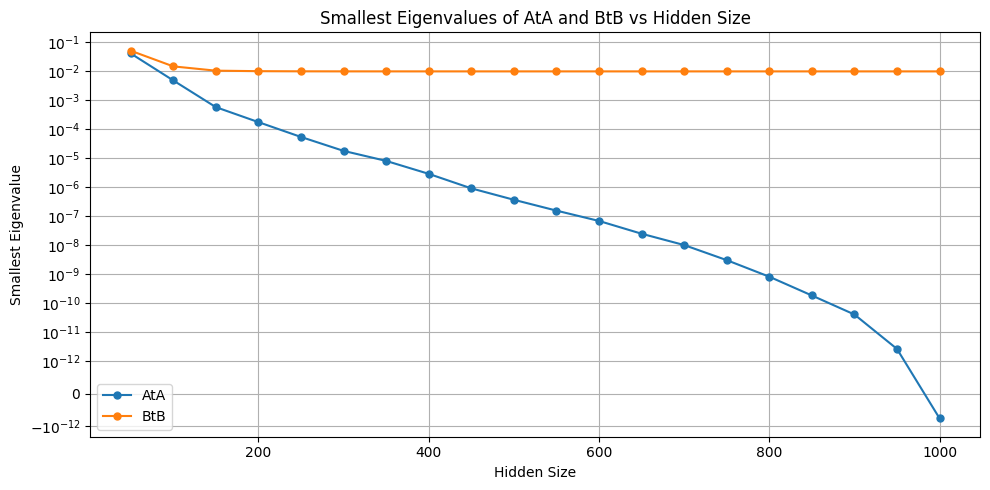

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(50, 1001, 50), eig_min_AtA_means, label="AtA", **marker_style)
plt.plot(range(50, 1001, 50), eig_min_BtB_means, label="BtB", **marker_style)
plt.xlabel("Hidden Size")
plt.ylabel("Smallest Eigenvalue")
plt.title("Smallest Eigenvalues of AtA and BtB vs Hidden Size")
plt.legend()
plt.yscale("symlog", linthresh=1e-12)
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Min_eigen")
plt.show()

## General experiments

### Experiments with small models

In [28]:
# hyperparameters

# per 2000 1e-2 alpha
# per 1000 1e-2 alpha
# per 100 1e-2 alpha
# per 50 1e-8 alpha

hidden_size_list = [3, 6, 10]  # [1000, 50, 100, 500]
lr_list = ["auto", "col"]  # "auto", "col"
beta_list = ["optimal"]  # "optimal"
alpha_list = [1e-2]
# epsilon_list = [np.float64(1e-10)]

# per 3 -12
# per 10 -11
# per 6 -11

In [29]:
worked = None
for HIDDEN_SIZE, LEARNING_RATE, BETA, ALPHA in itertools.product(
    hidden_size_list, lr_list, beta_list, alpha_list
):
    EPSILON = 1e-10 if HIDDEN_SIZE > 6 else 1e-11
    print(
        f"HIDDEN_SIZE: {HIDDEN_SIZE}, LEARNING_RATE: {LEARNING_RATE}, BETA: {BETA}, ALPHA: {ALPHA}, EPSILON: {EPSILON}"
    )
    # initialize dictionary for results
    results_dict = {
        "Hidden size": [],
        "Mu": [],
        "Beta": [],
        "Epsilon": [],
        "Alpha": [],
        "Seed": [],
        "Initialization type": [],
        "Train": [],
        "Time": [],
        "Time int": [],
        "Epochs": [],
    }

    # if worked is not None and not type(LEARNING_RATE) == str:
    #     if (
    #         LEARNING_RATE < worked
    #     ):  # an higher learning rate has already been tested, and it converged
    #         continue

    # loop over seeds
    for seed in range(0, 1):

        # compute exact solution using qr which has guaranteed better numerical stability
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        model_true.compute_wout_system_qr(X_train, y_train, alpha=ALPHA)

        # initialize model
        model = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)

        print("starting seed", seed)

        # measure time
        start = time.process_time()

        (
            final_model,
            loss_train_history,
            sol_dist_history,
            grad_history,
            epochs,
            exec_time_loop,
            has_problem,
        ) = nesterov.nag(
            model,
            X_train,
            y_train,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=150000,  # we are sure unless of numerical errors of the convergence, just here to prevent runs spanning hours
            eps=EPSILON,
            exact_solution=model_true.output_weights,
            # fast_mode=True,
            # verbose=True,
            # prec_error=1e-13,
        )

        # # Ensure the directory exists
        # os.makedirs("magic", exist_ok=True)

        # # Create a unique filename using alpha, hidden size, and seed
        # filename = f"magic/special_alpha{ALPHA}_hidden{HIDDEN_SIZE}_seed{seed}.pkl"

        # # Save the magic_number to the file
        # with open(filename, "wb") as f:
        #     pickle.dump(magic_number, f)

        # continue

        end = time.process_time()
        print(f"LUNGHEZZA: {len(sol_dist_history)}")

        if has_problem:
            print(
                f"Problem with ELM {HIDDEN_SIZE} {LEARNING_RATE} {BETA} {ALPHA} {EPSILON} {seed}"
            )
            continue
        else:
            worked = LEARNING_RATE

        # save results
        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append("fan-in")
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Time"].append(end - start)
        results_dict["Time int"].append(exec_time_loop)
        results_dict["Epochs"].append(epochs)

        # guard is true if not using fast_mode (i.e. all iterations are saved)
        if len(loss_train_history) > 1:
            # save all iterations using pickle
            with open(
                f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",
                "wb",
            ) as f:
                pickle.dump(
                    {
                        "model": final_model,
                        "loss_train_history": loss_train_history,
                        "sol_dist_history": sol_dist_history,
                        "grad_history": grad_history,
                    },
                    f,
                )
    if has_problem:
        continue

    # no results obtained because there was an error
    if len(results_dict["Seed"]) == 0:
        continue

    df_results = pd.DataFrame(results_dict)
    df_results.to_csv(
        f"{RESULTS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}-temp.csv",
        index=False,
    )

HIDDEN_SIZE: 3, LEARNING_RATE: auto, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-11
starting seed 0
0.0
Optimal Beta: 0.39650762906009973
LUNGHEZZA: 49
HIDDEN_SIZE: 3, LEARNING_RATE: col, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-11
starting seed 0
0.0
Optimal Beta: 0.39650762906009973
LUNGHEZZA: 50
HIDDEN_SIZE: 6, LEARNING_RATE: auto, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-11
starting seed 0
0.0
Optimal Beta: 0.7332934431168524
LUNGHEZZA: 193
HIDDEN_SIZE: 6, LEARNING_RATE: col, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-11
starting seed 0
0.0
Optimal Beta: 0.7332934431168524
LUNGHEZZA: 189
HIDDEN_SIZE: 10, LEARNING_RATE: auto, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-10
starting seed 0
0.0
Optimal Beta: 0.9249721109721232
LUNGHEZZA: 729
HIDDEN_SIZE: 10, LEARNING_RATE: col, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-10
starting seed 0
0.0
Optimal Beta: 0.9249721109721232
LUNGHEZZA: 730


### Experiments for diff beta

In [ ]:
# hyperparameters

# per 2000 1e-2 alpha
# per 1000 1e-2 alpha
# per 100 1e-2 alpha
# per 50 1e-8 alpha

hidden_size_list = [1000, 50, 100, 500]
lr_list = ["optimal"]
# beta_list = ["optimal"]
# alpha_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
# epsilon_list = [np.float64(1e-10)]

beta_list = [0.9, 0.3, 0.6, 0.99, 0, "schedule"]
alpha_list = [1e-2]
# epsilon_list = [np.float64(1e-10)]

In [ ]:
worked = None
for HIDDEN_SIZE, LEARNING_RATE, BETA, ALPHA in itertools.product(
    hidden_size_list, lr_list, beta_list, alpha_list
):
    EPSILON = 1e-9 if HIDDEN_SIZE >= 500 else 1e-10
    print(
        f"HIDDEN_SIZE: {HIDDEN_SIZE}, LEARNING_RATE: {LEARNING_RATE}, BETA: {BETA}, ALPHA: {ALPHA}, EPSILON: {EPSILON}"
    )
    # initialize dictionary for results
    results_dict = {
        "Hidden size": [],
        "Mu": [],
        "Beta": [],
        "Epsilon": [],
        "Alpha": [],
        "Seed": [],
        "Initialization type": [],
        "Train": [],
        "Time": [],
        "Time int": [],
        "Epochs": [],
    }

    # if worked is not None and not type(LEARNING_RATE) == str:
    #     if (
    #         LEARNING_RATE < worked
    #     ):  # an higher learning rate has already been tested, and it converged
    #         continue

    # loop over seeds
    for seed in range(0, 4):

        # compute exact solution using qr which has guaranteed better numerical stability
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        model_true.compute_wout_system_qr(X_train, y_train, alpha=ALPHA)

        # initialize model
        model = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)

        print("starting seed", seed)

        # measure time
        start = time.process_time()

        (
            final_model,
            loss_train_history,
            sol_dist_history,
            grad_history,
            epochs,
            exec_time_loop,
            has_problem,
        ) = nesterov.nag(
            model,
            X_train,
            y_train,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=1000000,  # we are sure unless of numerical errors of the convergence, just here to prevent runs spanning hours
            eps=EPSILON,
            exact_solution=model_true.output_weights,
            # fast_mode=True,
            # verbose=True,
        )
        # # Ensure the directory exists
        # os.makedirs("magic", exist_ok=True)

        # # Create a unique filename using alpha, hidden size, and seed
        # filename = f"magic/special_alpha{ALPHA}_hidden{HIDDEN_SIZE}_seed{seed}.pkl"

        # # Save the magic_number to the file
        # with open(filename, "wb") as f:
        #     pickle.dump(magic_number, f)

        # continue

        end = time.process_time()

        if has_problem:
            print(
                f"Problem with ELM {HIDDEN_SIZE} {LEARNING_RATE} {BETA} {ALPHA} {EPSILON} {seed}"
            )
            continue
        else:
            worked = LEARNING_RATE

        # save results
        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append("fan-in")
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Time"].append(end - start)
        results_dict["Time int"].append(exec_time_loop)
        results_dict["Epochs"].append(epochs)

        # guard is true if not using fast_mode (i.e. all iterations are saved)
        if len(loss_train_history) > 1:
            # save all iterations using pickle
            with open(
                f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",
                "wb",
            ) as f:
                pickle.dump(
                    {
                        "model": final_model,
                        "loss_train_history": loss_train_history,
                        "sol_dist_history": sol_dist_history,
                        "grad_history": grad_history,
                    },
                    f,
                )
    if has_problem:
        continue

    # no results obtained because there was an error
    if len(results_dict["Seed"]) == 0:
        continue

    df_results = pd.DataFrame(results_dict)
    df_results.to_csv(
        f"{RESULTS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}-trialnew4.csv",
        index=False,
    )

## Experiments for differing stepsize

In [ ]:
hidden_size_list = [1000, 500, 100, 50]
lr_list = [
    "auto",
    "col",
    1e-4,
    1e-5,
    1e-6,
    1e-7,
]
beta_list = ["optimal"]
alpha_list = [1e-2]
# epsilon_list = [np.float64(1e-10)]

In [18]:
worked = None
for (
    HIDDEN_SIZE,
    LEARNING_RATE,
    BETA,
    ALPHA,
) in itertools.product(hidden_size_list, lr_list, beta_list, alpha_list):
    EPSILON = 1e-9 if HIDDEN_SIZE >= 500 else 1e-10
    print(
        f"HIDDEN_SIZE: {HIDDEN_SIZE}, LEARNING_RATE: {LEARNING_RATE}, BETA: {BETA}, ALPHA: {ALPHA}, EPSILON: {EPSILON}"
    )
    # initialize dictionary for results
    results_dict = {
        "Hidden size": [],
        "Mu": [],
        "Beta": [],
        "Epsilon": [],
        "Alpha": [],
        "Seed": [],
        "Initialization type": [],
        "Train": [],
        "Time": [],
        "Time int": [],
        "Epochs": [],
    }

    # if worked is not None and not type(LEARNING_RATE) == str:
    #     if (
    #         LEARNING_RATE < worked
    #     ):  # an higher learning rate has already been tested, and it converged
    #         continue

    # loop over seeds
    for seed in range(0, 4):

        # compute exact solution using qr which has guaranteed better numerical stability
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        model_true.compute_wout_system_qr(X_train, y_train, alpha=ALPHA)

        # initialize model
        model = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)

        print("starting seed", seed)

        # measure time
        start = time.process_time()

        # train model
        (
            final_model,
            loss_train_history,
            sol_dist_history,
            grad_history,
            epochs,
            exec_time_loop,
            has_problem,
        ) = nesterov.nag(
            model,
            X_train,
            y_train,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=1000000,  # we are sure unless of numerical errors of the convergence, just here to prevent runs spanning hours
            eps=EPSILON,
            exact_solution=model_true.output_weights,
            fast_mode=True,
            # verbose=True,
        )

        end = time.process_time()

        if has_problem:
            print(
                f"Problem with ELM {HIDDEN_SIZE} {LEARNING_RATE} {BETA} {ALPHA} {EPSILON} {seed}"
            )
            continue
        else:
            worked = LEARNING_RATE

        # save results
        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append("fan-in")
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Time"].append(end - start)
        results_dict["Time int"].append(exec_time_loop)
        results_dict["Epochs"].append(epochs)

        # guard is true if not using fast_mode (i.e. all iterations are saved)
        if len(loss_train_history) > 1:
            # save all iterations using pickle
            with open(
                f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",
                "wb",
            ) as f:
                pickle.dump(
                    {
                        "model": final_model,
                        "loss_train_history": loss_train_history,
                        "sol_dist_history": sol_dist_history,
                        "grad_history": grad_history,
                    },
                    f,
                )

    if has_problem:
        continue

    # no results obtained because there was an error
    if len(results_dict["Seed"]) == 0:
        continue

    df_results = pd.DataFrame(results_dict)
    df_results.to_csv(
        f"{RESULTS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}-trialnew3.csv",
        index=False,
    )

HIDDEN_SIZE: 1000, LEARNING_RATE: auto, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-09
starting seed 0
9.288004505183867e-13
starting seed 1
6.289799724600792e-13
starting seed 2
7.208872809308787e-13
starting seed 3
7.806570919077106e-13
HIDDEN_SIZE: 1000, LEARNING_RATE: col, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-09
starting seed 0
9.288004505183867e-13
starting seed 1
6.289799724600792e-13
starting seed 2
7.208872809308787e-13
starting seed 3
7.806570919077106e-13
HIDDEN_SIZE: 1000, LEARNING_RATE: 0.0001, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-09
starting seed 0
9.288004505183867e-13
Problem with ELM 1000 0.0001 optimal 0.01 1e-09 0
starting seed 1
6.289799724600792e-13
Problem with ELM 1000 0.0001 optimal 0.01 1e-09 1
starting seed 2
7.208872809308787e-13
Problem with ELM 1000 0.0001 optimal 0.01 1e-09 2
starting seed 3
7.806570919077106e-13
Problem with ELM 1000 0.0001 optimal 0.01 1e-09 3
HIDDEN_SIZE: 1000, LEARNING_RATE: 1e-05, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-09
starting s

### experiments for different alpha

In [6]:
# hyperparameters

# per 2000 1e-2 alpha
# per 1000 1e-2 alpha
# per 100 1e-2 alpha
# per 50 1e-8 alpha

hidden_size_list = [50]  # [1000, 50, 100, 500]
lr_list = ["optimal"]
beta_list = ["optimal"]
alpha_list = [1e-2]  # [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
# epsilon_list = [np.float64(1e-10)]

# beta_list = [0.9, 0.3, 0.6, 0.99, 0, "schedule"]
# alpha_list = [1e-2]
# epsilon_list = [np.float64(1e-10)]

In [ ]:
worked = None
for HIDDEN_SIZE, LEARNING_RATE, BETA, ALPHA in itertools.product(
    hidden_size_list, lr_list, beta_list, alpha_list
):
    EPSILON = 1e-9 if HIDDEN_SIZE >= 500 else 1e-10
    print(
        f"HIDDEN_SIZE: {HIDDEN_SIZE}, LEARNING_RATE: {LEARNING_RATE}, BETA: {BETA}, ALPHA: {ALPHA}, EPSILON: {EPSILON}"
    )
    # initialize dictionary for results
    results_dict = {
        "Hidden size": [],
        "Mu": [],
        "Beta": [],
        "Epsilon": [],
        "Alpha": [],
        "Seed": [],
        "Initialization type": [],
        "Train": [],
        "Time": [],
        "Time int": [],
        "Epochs": [],
    }

    # if worked is not None and not type(LEARNING_RATE) == str:
    #     if (
    #         LEARNING_RATE < worked
    #     ):  # an higher learning rate has already been tested, and it converged
    #         continue

    # loop over seeds
    for seed in range(0, 1):

        # compute exact solution using qr which has guaranteed better numerical stability
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        model_true.compute_wout_system_qr(X_train, y_train, alpha=ALPHA)

        # initialize model
        model = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)

        print("starting seed", seed)

        # measure time
        start = time.process_time()

        # train model
        (
            final_model,
            loss_train_history,
            sol_dist_history,
            grad_history,
            epochs,
            exec_time_loop,
            has_problem,
        ) = nesterov.nag(
            model,
            X_train,
            y_train,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=150000,  # we are sure unless of numerical errors of the convergence, just here to prevent runs spanning hours
            eps=1e-15,
            exact_solution=model_true.output_weights,
            check_float64=True,
            # fast_mode=True,
            precision=np.float32,
            # verbose=True,
        )

        print(min(grad_history))
        print(type(min(grad_history)))
        print(type(grad_history))

        end = time.process_time()

        if has_problem:
            print(
                f"Problem with ELM {HIDDEN_SIZE} {LEARNING_RATE} {BETA} {ALPHA} {EPSILON} {seed}"
            )
            continue
        else:
            worked = LEARNING_RATE

        # save results
        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append("fan-in")
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Time"].append(end - start)
        results_dict["Time int"].append(exec_time_loop)
        results_dict["Epochs"].append(epochs)

        # guard is true if not using fast_mode (i.e. all iterations are saved)
        if len(loss_train_history) > 1:
            # save all iterations using pickle
            with open(
                f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",
                "wb",
            ) as f:
                pickle.dump(
                    {
                        "model": final_model,
                        "loss_train_history": loss_train_history,
                        "sol_dist_history": sol_dist_history,
                        "grad_history": grad_history,
                    },
                    f,
                )

    if has_problem:
        continue

    # no results obtained because there was an error
    if len(results_dict["Seed"]) == 0:
        continue

    df_results = pd.DataFrame(results_dict)
    df_results.to_csv(
        f"{RESULTS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}-trialnew5.csv",
        index=False,
    )

HIDDEN_SIZE: 50, LEARNING_RATE: optimal, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-10
starting seed 0
0.0
Optimal Beta: 0.9951791167259216
Optimal lr: 0.00010604110138956457
0.02432441
<class 'numpy.float32'>
<class 'list'>
